# flashing_lights.GenerateIntensityMap() Example Notebook

* This function is used to generate an accumulation of intensity calues for single pixels throughout the duration of an image stack. It is a particularly useful function for researchers presenting spatial features present within the image stck

* Typical video formats include .mp4 and .tif; video format must be supported by opencv to be input correctly for this function

### Part 1 - Importing Necessary Modules

* For the code to run properly, we require a stack of modules that are available within the flashing_lights_env virtual environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from GenerateIntensityMap import GetIntensityValues
from GenerateIntensityMap import GetIntensityArray
from GenerateIntensityMap import IntensityMap

### Part 2 - Loading Video Files to Use

In [2]:
test_video = '/Users/mcalli75/Desktop/brain_slice_video.tif'

The above video is an image stack of stained neurons within a brain slice. Stained portions of the image have associated brightnesses, which we hope to record the intensity of for a heat map. 

### Part 3 - Obtaining Intensity Values of a Single Image
* To accumulate the Intensity of brightness events within a video, we first need a function which can obtain the coordinates of pixels where events occur in each frame. To do this, we created a function that searches through a frame for pixels brighter than a given threshold, then stores the pixel brightness in the location of the event. Pixels with brightness values below the threshold are ignored. 
* Here is the code:

```
def GetIntensityValues(frame, threshold):
    """Searches through an image to find greyscale pixels above a certain
    brightness threshold. If pixels of sufficient brightness are present
    within the image the coordinates of the pixel are stored and the
    brightness is added to an empty array

    Inputs:

    - frame: ndarray of pixels (image file or video frame)
    - threshold: minimum brightness for an event detection

    Output: an ndarray of intensity values for
    pixels above the brightness threshold in the frame

    """
     # Generating empty matrix for coordinate assignment
    intensities = np.zeros(np.shape(frame))
    # Generating index lists to keep track of ROI coordinates
    index_count_row = []
    index_count_col = []
    # Looks through matrix for points above a brightness threshold
    if len(np.where(frame >= threshold)) > 0:
        # Finding coordinates of brightness events
        row, col = np.where(frame >= threshold)
        for i in range(len(row)):
            for j in range(len(col)):
                # Adds intensity value in the position of the
                # given brightness event
                intensities[row[i], col[j]] = frame[row[i], col[j]]
                index_count_row.append(row[i])
                index_count_col.append(col[j])
    else:
        pass
    return intensities
```

**To run the code we just need a video file, for now we will set the brightness threshold as 5**

In [3]:
# Reading in video file to use in code
ret, img = cv2.imreadmulti(test_video, flags = cv2.IMREAD_GRAYSCALE)

In [4]:
# This image has an incredibly large number of pixels (4252 x 7070)
# To reduce the computational cost of this example, it has been resized to (42, 70)
# 
# Setting Resizing Dimensions
scale_percent = 1
width = int(img[0].shape[1] * scale_percent / 100)
height = int(img[0].shape[0] * scale_percent / 100)
dim = (width, height)
img_resized = cv2.resize(img[0], dim, interpolation = cv2.INTER_AREA)

In [6]:
# Running the code 
int_val = GetIntensityValues(img_resized, 5)

In [7]:
# Finding where events occurred  
row, col = np.where(int_val >= 1)
int_coord = pd.DataFrame({'X':row, 'Y': col})
int_coord

,X,Y
0,6,11
1,6,14
2,6,15
3,6,25
4,6,28
...,...,...
410,26,50
411,26,51
412,26,52
413,26,53


So based on our threshold, 415 brightness events occurred, and our function allows us to quickly determine the coordinates of each point.

### Part - 4 Obtaining Intensity Values of a Single Image
* Since our first function can pull out event coordinates in a single image, we need a function which can iterate through each frame in the video, storing an additional intensity value for every time a pixel lights up. From the output of this function, we can map our accumulated intensities over a blank image to produce a heatmap
* Here is the code:

```
def GetIntensityArray(videofile, threshold, scale_percent):
    """Finds pixel coordinates within a videofile (.tif, .mp4) for pixels
    that are above a brightness threshold, then accumulates the
    brightness event intensities for each coordinate,
    outputting it as a 2-D array in the same size as the video frames

    Input:
    -videofile: file containing an image stack of fluorescent events
    -threshold: minimum brightness for detection
    -scale_percent: helps resize image for faster computing speeds

    Output: 2-d Array of accumulated intensity values for each pixel above
    a calculated brightness threshold in the video"""
    # Reading video file and convert to grayscale
    ret, img = cv2.imreadmulti(videofile, flags=cv2.IMREAD_GRAYSCALE)
    # Setting Resizing Dimensions
    width = int(img[0].shape[1] * scale_percent / 100)
    height = int(img[0].shape[0] * scale_percent / 100)
    dim = (width, height)
    img_resized = cv2.resize(img[0], dim, interpolation = cv2.INTER_AREA)
    # Creating empty array to add intensity values to
    int_array = np.zeros(np.shape(img_resized))
    for frame in range(len(img)):
        # Resize Frame
        frame_resized = cv2.resize(img[frame],
                                    dim, interpolation = cv2.INTER_AREA)
        intensity = GetIntensityValues(frame_resized, threshold)
        if len(np.where(intensity >= 1)) > 0:
            # Get coordinates of the single pixel counts
            row, col = np.where(intensity >= 1)
            for i in range(len(row)):
                for j in range(len(col)):
                    # Add single count to freq_array in location of event
                    int_array[row[i], col[j]] += intensity[row[i], col[j]]
        else:
            pass
    return int_array
```

* **This code is much longer and more complicated than the last, but it only needs a videofile, threshold and scale factor. to run.**
* **The scale_percent variable is used to reduce image sizes for faster processing speeds**

In [8]:
x = GetIntensityArray(test_video, 5, 1)

In [9]:
np.shape(x)

(42, 70)

In [10]:
x.max()

3780.0

### Part - 5 Generating the Intensity Map
* Now that we have an array of total intensity values, we just need to map them onto a blank image to get our heatmap. 
* Here is the code:

```
def IntensityMap(videofile, threshold, scale_percent, img_path, img_name):
    """Takes intensity accumulation array from
    GenerateIntensityMap.GetIntensityArray() and plots it as
    a colored meshgrid.

    Yellow pixels are at max intensity, blue pixels are
    minimum intensity (cmap = 'plasma')"""
     # Reading video file
    ret, img = cv2.imreadmulti(videofile, flags=cv2.IMREAD_GRAYSCALE)
    # obtaining frequency array
    z = GetIntensityArray(videofile, threshold, scale_percent)
    # Generating x and y axes in shape of image frame
    width = int(img[0].shape[1] * scale_percent / 100)
    height = int(img[0].shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    frame_resized = cv2.resize(img[0], dim, interpolation = cv2.INTER_AREA)
    pixel_X = np.arange(0, frame_resized.shape[1])
    pixel_Y = np.arange(0, frame_resized.shape[0])
    # Mapping intensity array onto the x and y axes
    fig = plt.pcolormesh(pixel_X, pixel_Y, z, cmap='plasma')
    plt.xlabel('Pixel Count')
    plt.ylabel('Pixel Count')
    plt.title('Intensity Map')
    plt.colorbar()
    # picture is saved in file location designated by user
    plt.savefig(img_path + '/' + img_name + '.png', bbox_inches='tight')
    return fig
```

CPU times: user 1.47 s, sys: 107 ms, total: 1.58 s
Wall time: 1.65 s


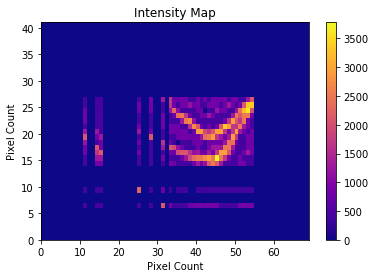

In [11]:
%time IntensityMap(test_video, 5, 1, '.', 'int_acc_map_lowres_notallfeatures')

So the code ran, and a map was produced, but it does not contain the features we want. To see more features we must reduce the brightness threshold to a lower value. Lets try a value of 1 instead of 5.

CPU times: user 29.1 s, sys: 1.01 s, total: 30.1 s
Wall time: 31.5 s


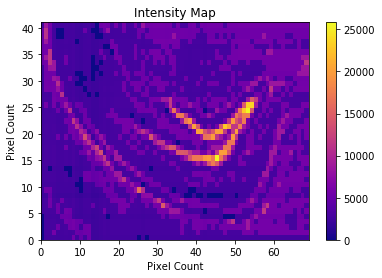

In [12]:
%time IntensityMap(test_video, 1, 1, '.', 'int_acc_map_allfeatures')

Great! We see plenty more features now that the brightness threshold was lower, and the code only took ~30s to run. The resolution could be much better though. Let's use a scale factor of 2 instead of 1 to see if we can have better resolved features.

CPU times: user 7min 25s, sys: 39.6 s, total: 8min 4s
Wall time: 9min 5s


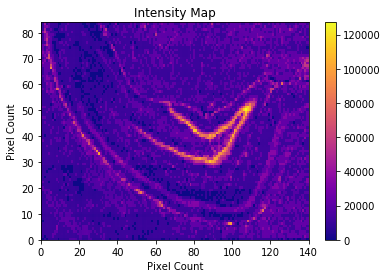

In [14]:
%time IntensityMap(test_video, 1, 3, '.', 'int_acc_map_highres')

Even better! However it is worth noting the time which it took to run this code; increasing the scale percent from 1 to 2 percent led to the code taking ~17 times longer to run. An extremely resolved output will require a long time to process, so before trying out this code, or the frequency accumulation, be sure to check the file size and pixel count of your image. Large files (many frames) and large pixel counts will drastically slow down the code. 